# **CONVOLUTIONAL NEURAL NETWORK (CNN)**

## Problem

Train a CNN on the [CIFAR-10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10).

Note: Use tfds.

## Initialize

In [1]:
import cv2
import csv
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Inputs

In [3]:
# input image size
INPUT_SIZE = (32, 32, 3)

# number of classes
NUM_CLASSES = 10

# batch size
BATCH_SIZE = 16

# directory for log
DIR_LOG = '04-logs'

## Dataset

**Note**
- The `cifar10` dataset has two splits - `'train'` and `'test'`.
- However, we would like to further divide the `'train'` split to `'train'` (80%) and `'valid'` (20%) subsplits.
- To split and slice datasets, see [these guidelines](https://www.tensorflow.org/datasets/splits#specifying_a_percentage_slice).

In [4]:
# load the dataset
ds_train, ds_valid, ds_test = tfds.load(
    name='cifar10',
    split=[
        tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
        tfds.Split.TRAIN.subsplit(tfds.percent[80:]),
        tfds.Split.TEST
    ],
    batch_size=BATCH_SIZE,
    as_supervised=True,
    shuffle_files=False
)

## Data Augmentation

[See tensorflow docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

**Note**
- We perform augmentation only for the training images.
- We normalize all training, validation, and testing images.
- We do not need to shuffle the validation and testing images.

In [5]:
# generate image data with normalization and augmentation
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2),
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
)

# generate image data only with normalization
test_datagen = ImageDataGenerator(
    rescale=1 / 255.,
)

# define a function for applying augmentation on training data
@tf.function
def train_transform(image, label):
    # random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # random crop
    image = tf.image.random_crop(image, [28, 28, 3])
    image = tf.image.resize(image, INPUT_SIZE[:2])
    # random brightness
    image = tf.image.random_brightness(image, 0.2)
    # random hue
    image = tf.image.random_hue(image, 0.2)
    # clippling
    image = tf.clip_by_value(image, 0., 1.)
    # return
    return image, label

# convert to float
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32)/255., y)).cache()
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32)/255., y)).cache()
ds_test = ds_test.map(lambda x, y: (tf.cast(x, tf.float32)/255., y)).cache()

# apply training augmentation
ds_train = ds_train.unbatch().map(train_transform).batch(BATCH_SIZE)

#### Check one image

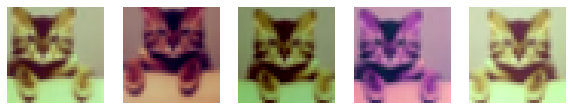

In [6]:
# get one image
ds_trial = ds_train.unbatch().take(1).repeat(5)

# plot
plt.figure(figsize=(10, 2))
for i, (x, y) in enumerate(ds_trial):
    plt.subplot(1, 5, i+1)
    plt.imshow(x)
    plt.axis('off')
plt.show()

## Model

**Note**
- The problem is multi-class classification.
- Use `'softmax'` activation function in the output layer.
- Labels are of ordinal category.
- Use `'sparse_categorical_crossentropy'` loss.

In [7]:
# input layer
input_tensor = Input(shape=INPUT_SIZE)

# convolution layers
x = Conv2D(16, 3, activation='relu')(input_tensor)
x = MaxPool2D()(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D()(x)

# fully-connected layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# output layer with 'softmax' activation function
output_tensor = Dense(NUM_CLASSES, activation='softmax')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'sparse_categorical_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584

## Callback

- You can use [pre-defined callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).
- Or, you can define custom callback to have more control over what happens during the training or prediction.
[See more](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).


**`ReduceLROnPlateau()`**
- Reduces the learning rate by a factor (defined in `factor`)
if the monitored metric (defined in`monitor`) does not improve
for a number of consecutive eporchs (defined in `patience`).

**`EarlyStopping()`**
- Stops the training if the monitored metric (defined in`monitor`)
does not improve by a defined amount (`min_delta`)
for a number of consecutive eporchs (defined in `patience`).

**`TensorBoard()`**
- Enables tensorboard visualization.
- Launce from commandline: ```tensorboard --logdir=path_to_your_logs```

**Note**
- For metric that needs to be decreasing (e.g., loss), use `mode='min'` or `mode='auto'` (default).
- For metric that needs to be increasing (e.g., accuracy), use `mode='max'`.

In [8]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='val_acc', mode='max', factor=0.1, patience=3, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='val_acc',  mode='max', min_delta=0, patience=10, verbose=2, restore_best_weights=True
)

# visualize in tensorboard
tensorboard = TensorBoard(log_dir=DIR_LOG)

# commandline from root directory:
# tensorboard --logdir=02-Computer-Vision/04-logs

## Training

In [9]:
# train the model
hist = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs=100,
    verbose=1,
    callbacks=[reduce_rl, early_stopping, tensorboard]
)

Epoch 1/100
2500/2500 [==============================] - 15s 6ms/step - loss: 1.6900 - acc: 0.3820 - val_loss: 1.3730 - val_acc: 0.5128
Epoch 2/100
2500/2500 [==============================] - 9s 4ms/step - loss: 1.3732 - acc: 0.5087 - val_loss: 1.2430 - val_acc: 0.5702
Epoch 3/100
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2283 - acc: 0.5647 - val_loss: 1.2221 - val_acc: 0.5905
Epoch 4/100
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1297 - acc: 0.6031 - val_loss: 1.2236 - val_acc: 0.6021
Epoch 5/100
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0519 - acc: 0.6303 - val_loss: 1.2646 - val_acc: 0.6011
Epoch 6/100
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9853 - acc: 0.6556 - val_loss: 1.2805 - val_acc: 0.6052
Epoch 7/100
2500/2500 [==============================] - 9s 4ms/step - loss: 0.9230 - acc: 0.6775 - val_loss: 1.3583 - val_acc: 0.5985
Epoch 8/100
2500/2500 [=============================

**Save model**

`model.save()`
- Saves entire model (architecture, weight, and state).
- To load, use `tf.keras.models.load_model()`.

`model.save_weights()`
- Saves only the weights.
- To load, build the model first. Then, `model.load_weights`.

In [10]:
# save the entire model
model.save(DIR_LOG + '/cnn_model.h5', include_optimizer=False)

## Evauation

In [11]:
# get prediction on the test images
y_pred = model.predict(ds_test)

if NUM_CLASSES == 2:
    # for binary classification
    y_pred = y_pred > 0.5
elif NUM_CLASSES > 2:
    # for multi-clas classification
    y_pred = np.argmax(y_pred, axis=1)

**Confusion matrix**

In [12]:
# get the y_test values
for _, y_test in ds_test.unbatch().batch(10000):
    break

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

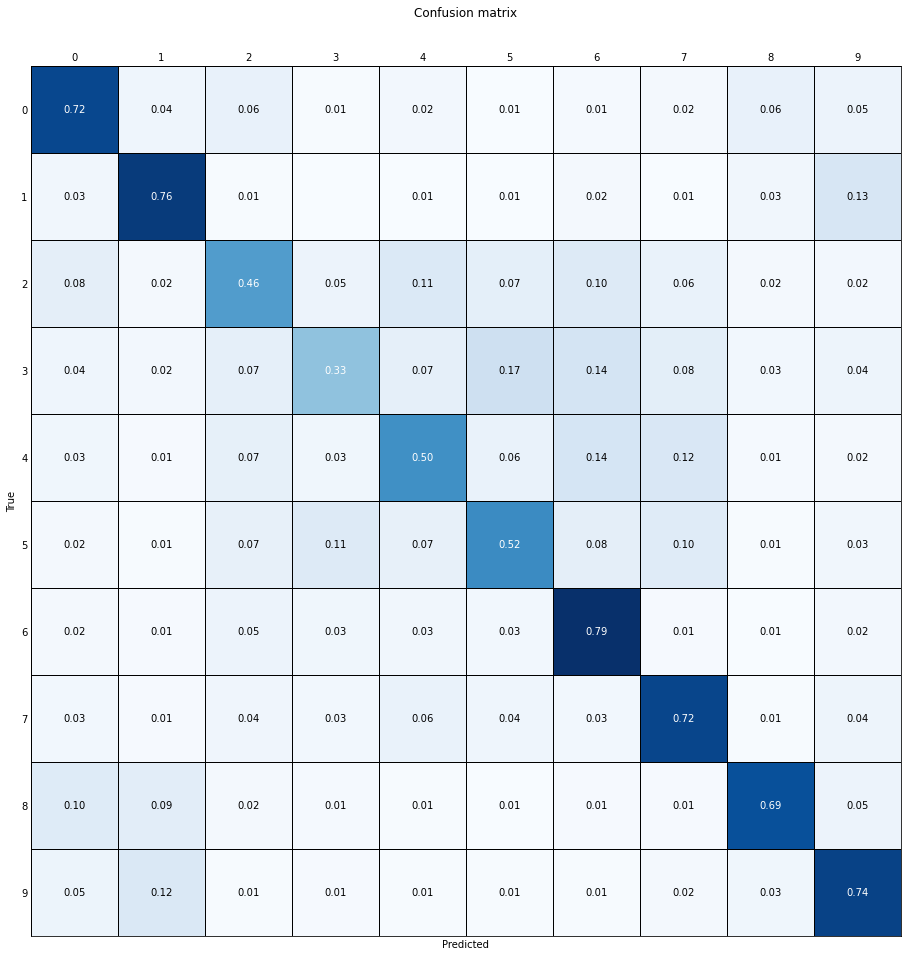

In [13]:
# get name of the classes
labels = list(range(NUM_CLASSES))
# get indices of the classes
indices = list(range(NUM_CLASSES))

# figure for displaying the confusion matrix
fig = plt.figure(figsize=(16, 16))
ax = fig.gca()

# display the confution matrix
cax = ax.matshow(conf_mat, cmap='Blues')

# show the values
for (i, j), z in np.ndenumerate(conf_mat):
    text_color = 'w' if i == j else 'k'
    if z < 0.005:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c=text_color)

# title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# show class names
plt.xticks(indices, labels)
plt.yticks(indices, labels)
ax.tick_params(axis='both', which='both', length=0)

# show grid lines
ax.set_xticks(np.arange(-.5, NUM_CLASSES, 1), minor=True)
ax.set_yticks(np.arange(-.5, NUM_CLASSES, 1), minor=True)
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

plt.show()

**Other metrics**

In [14]:
# calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

In [15]:
# pandas data frame for storing the metrics
df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
}
)

# calculate the mean
df.loc['(Average)'] = df.mean()

# display
df

,Precision,Recall,F1-score
0,0.650407,0.7200,0.683436
1,0.694215,0.7560,0.723791
2,0.537471,0.4590,0.495146
3,0.529316,0.3250,0.402726
4,0.564334,0.5000,0.530223
5,0.567181,0.5150,0.539832
6,0.590604,0.7920,0.676634
7,0.629887,0.7250,0.674105
8,0.768805,0.6950,0.730042
9,0.642234,0.7360,0.685927
